In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

#Evaluation Metric
from sklearn.metrics import r2_score  # how well we are explaining our variants wrt regression
from sklearn.metrics import cohen_kappa_score  
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import mlxtend
import joblib
import pickle
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS   #Forward Feature Selection

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Filtering DataFrame**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/IntelliTech-DataSet/Features/EssaySet07_Features_modified.csv", index_col =0)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0.1,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score,Rater 1 Trait 1,Rater 1 Trait 2,Rater 1 Trait 3,Rater 1 Trait 4,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy
0,0,17834,Patience is when your waiting .I was patience ...,8,7,15,1,2,2,3,...,0.594544,8.394449,73.625000,9.994286,6.716135,57,0.558824,66,0.000182,4
1,1,17836,"I am not a patience person, like I can’t sit i...",6,7,13,1,1,2,2,...,0.506446,30.723968,79.458571,10.098421,7.026690,50,0.476190,60,0.000160,3
2,2,17837,One day I was at basketball practice and I was...,7,8,15,1,2,2,2,...,0.000000,81.000000,-58.751053,67.798387,13.595527,72,0.421053,105,0.000230,2
3,3,17838,I going to write about a time when I went to t...,8,9,17,2,2,2,2,...,0.313401,16.943137,102.012685,4.382090,6.068846,112,0.413284,151,0.000358,2
4,4,17839,It can be very hard for somebody to be patient...,7,6,13,1,2,2,2,...,0.458976,11.707205,98.979560,1.631869,5.954910,67,0.370166,103,0.000214,1


In [ ]:
feats = ['Trait 1', 'Trait 2', 'Trait 3', 'Trait 4', 
       'Sent_Count', 'Word_Count', 'Char_Count',
       'Avg_Word_Count', 'Avg_Sentence_Length', 'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count',
       'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count',
       'Spelling_Mistakes_Count','Count_Fullstops', 'Count_Exclamation',
       'Count_Comma', 'Count_Questionmark', 'Count_Hyphens',
       'Capitalization_Errors', 'Grammar_Error_Count', 'Semantic_Similarity', 'Connectivity_Index',
       'Flesch_Reading_Ease_Score', 'Flesh_Kincaid_Grade',
       'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity',
       'Lexical_Density', 'Lexical_Originality', 'Lexical_Accuracy']
df_train = df.loc[:, df.columns.isin(feats)]

In [ ]:
df_essay= df['Essay']
df_essay

0       Patience is when your waiting .I was patience ...
1       I am not a patience person, like I can’t sit i...
2       One day I was at basketball practice and I was...
3       I going to write about a time when I went to t...
4       It can be very hard for somebody to be patient...
                              ...                        
1564    One time I was getting a cool @CAPS1 game it w...
1565    A patent person in my life is my mom. Aicason ...
1566    A time when someone else I know was patient wa...
1567    I hate weddings. I love when people get marrie...
1568    A few weeks ago, we had a garage sale and a mo...
Name: Essay, Length: 1569, dtype: object

In [ ]:
df_train.head()

,Trait 1,Trait 2,Trait 3,Trait 4,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Syllable_Count,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy
0,2,4,4,5,3,102,488,3.901961,34.000000,119,...,0.594544,8.394449,73.625000,9.994286,6.716135,57,0.558824,66,0.000182,4
1,3,3,4,3,3,105,459,3.476190,35.000000,114,...,0.506446,30.723968,79.458571,10.098421,7.026690,50,0.476190,60,0.000160,3
2,3,4,4,4,1,171,770,3.578947,171.000000,186,...,0.000000,81.000000,-58.751053,67.798387,13.595527,72,0.421053,105,0.000230,2
3,4,4,4,5,13,271,1124,3.350554,20.846154,268,...,0.313401,16.943137,102.012685,4.382090,6.068846,112,0.413284,151,0.000358,2
4,2,4,3,4,12,181,809,3.640884,15.083333,198,...,0.458976,11.707205,98.979560,1.631869,5.954910,67,0.370166,103,0.000214,1


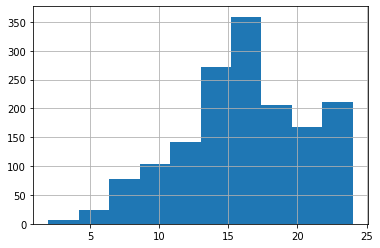

In [ ]:
df['Total Score'].hist()

## **Box Whisker**

In [ ]:
df['Total Score'].describe() 

count    1569.00000
mean       16.06246
std         4.58535
min         2.00000
25%        13.00000
50%        16.00000
75%        19.00000
max        24.00000
Name: Total Score, dtype: float64

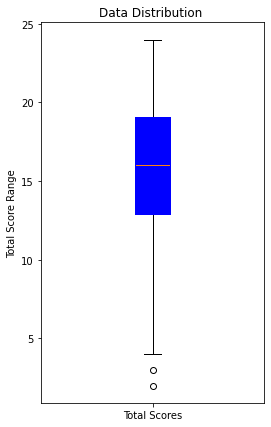

In [ ]:
plt.figure(figsize =(4,7))   #Vertical box-plots gives good visualization
plt.style.use("default")
boxes = plt.boxplot(df['Total Score'], labels= ['Total Scores'], patch_artist = True)
plt.title("Data Distribution ")
plt.ylabel("Total Score Range")
for box in boxes['boxes']:
    box.set(color = "blue", linewidth= 3, hatch= '/', facecolor= "orange")
plt.show()

# **Approach01: Traditional Features**

## **Model Training**


In [ ]:
log_df = pd.DataFrame(columns = ['modelName', 'features_list', 'features_size', 'hyperparameters','comments','r2-score', 'mae','cohen_kappa_score'])

In [ ]:
class MultiOutput_Regressor:
    modelName = "",       
    features_list = list(),
    features_size = 0,
    hyperparameters = dict(),
    comments = "",
    r2_score = 0,
    mae = 0,
    cohen_kappa_score = 0

    def  __init__(self, modelName, feature_list, features_size):
      self.modelName = modelName
      self.features_list = feature_list
      self.features_size = features_size
  ############################################ Calculate Score ####################################################
    def calculate_score(self,y_pred):
      total = list()
      for i in range(len(y_pred)):
        score = sum(y_pred[i])
        total.append(np.floor(score))
      print(total)
      return total

  ############################################### Linear Regression ######################################################
    def linearRegression(self,X,y):
      lr = LinearRegression()
      lr.fit(X, y)
      y_pred = lr.predict(X)
      importances = lr.coef_

      sorted_weights = np.sort(importances)[::-1]
      for weight in sorted_weights:
        print("Weight:", weight)
      sorted_indices = np.argsort(np.abs(importances))[::-1]
      print(sorted_indices)
      # for i in sorted_indices:
      #   print(f"Feature {i}: {importances[i]:.3f}")
      
      total_pred = self.calculate_score(y_pred)
      total_actual = df['Total Score']
      self.r2_score = r2_score(total_pred,total_actual)*100
      self.mae = mean_absolute_error(total_pred,total_actual)
      self.cohen_kappa_score = cohen_kappa_score(total_pred, total_actual,weights="quadratic")
      self.add_log()
      return lr
  
  ############################################ GridSearchCV Lasso And Ridge ############################################
    def gridSearchCV(self,X,y,modelName):
      if modelName == 'Ridge':
        labeler = "ridge_regression"
        model = Ridge()
      elif modelName == 'Lasso':
        labeler = "lasso_regression"
        model = Lasso()

      estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures()),
        (labeler, model)])
      # The name of paramas should be similar to that mentioned in estimators, ending with two underscores and param name.
      params = {
        'polynomial_features__degree': [1, 2, 3],
         #labeler+'__alpha': np.geomspace(4, 20, 30)
         labeler+'__alpha' : np.geomspace(1e-9, 1e0, num=10)
        }
      kf = KFold(shuffle=True, random_state=72018, n_splits=3)  
      self.no_of_kfolds =3
      grid = GridSearchCV(estimator, params, cv=kf)
      grid.fit(X, y)
      y_pred = grid.predict(X)
      print("gridCBV best scores: " ,grid.best_score_)
      #weights = grid.named_steps["lasso_regression"].coef_
      #print(weights)
      self.hyperparameters= grid.best_params_
      total_pred = self.calculate_score(y_pred)
      total_actual = df['Total Score']
      self.r2_score = r2_score(total_pred,total_actual)*100
      self.mae = mean_absolute_error(total_pred,total_actual)
      self.cohen_kappa_score = cohen_kappa_score(total_pred, total_actual,weights="quadratic")
      self.add_log()

   ################################### Random Forest ###########################################
    def randomforest_regressor(self,X,y,model_scaler):
       '''Note: Scaling is done to make the target variable continous (suitable for multioutput regression),
        Otherwise it will give the error of OOB Score which is measure of the model's performance on unseen data. 
        It is only supported for certain types of targets, such as continuous, binary, or multiclass data.'''
       rf = RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = 50)
       rf.fit(X, y)
       y_pred = rf.predict(X)
       y_pred= model_scaler.inverse_transform(y_pred)
       total_pred = self.calculate_score(y_pred)
       total_actual = df['Total Score']
       self.r2_score = r2_score(total_pred,total_actual)*100
       self.mae = mean_absolute_error(total_pred,total_actual)
       self.cohen_kappa_score = cohen_kappa_score(total_pred, total_actual,weights="quadratic")
       self.add_log()
       return rf

  ############################### Utility Function ######################################################
    def get_models(self):
     models = list()
     models 
     models.append(ensemble.GradientBoostingRegressor(random_state=0,learning_rate=0.01, n_estimators=500, subsample=0.5))
     models.append(DecisionTreeRegressor())
     # models.append(LinearRegression())  NOTE: Idk why linear regression is giving a 100% accuracy, maybe because of y_test split, anywsys removing it from here.
     models.append(KNeighborsRegressor())
     return models
     
  ################################### MultiOutput Model ####################################################
    def multiOuput_regressor(self,X,y):
      for model in self.get_models():
        print(model)
        m = MultiOutputRegressor(model).fit(X, y)
        y_pred = m.predict(X)
        total_pred = self.calculate_score(y_pred)
        total_actual = df['Total Score']
        self.r2_score = r2_score(total_pred,total_actual)*100
        self.mae = mean_absolute_error(total_pred,total_actual)
        self.cohen_kappa_score = cohen_kappa_score(total_pred, total_actual,weights="quadratic")
        self.add_log()


  ################################# Gradient Boosting Regressor Basic #####################################
    def gbr_basic(self, X, y, learningRate=0.01, nEstimator=500, subSample=0.5 ):
      gbr = MultiOutputRegressor(ensemble.GradientBoostingRegressor(learning_rate= learningRate, n_estimators= nEstimator, subsample= subSample))
      gbr.fit(X, y)
      y_pred = gbr.predict(X)
      self.hyperparamters = dict(learning_rate= learningRate, n_estimators= nEstimator, subsample= subSample)
      total_pred = self.calculate_score(y_pred)
      total_actual = df['Total Score']
      self.r2_score = r2_score(total_pred,total_actual)*100
      self.mae = mean_absolute_error(total_pred,total_actual)
      self.cohen_kappa_score = cohen_kappa_score(total_pred, total_actual,weights="quadratic")
      self.add_log()
      return gbr

  ############################################ Cohen Kappa Score ###################################################
  # # Doesn't work for multioutput regression, hence calculating the score for each score and then averaging it out.
  #   def cohen_kappa_score_eval(self,y_test,y_pred):
  #     cohen_values = list()
  #     for i in range(0,8):     # 4 traits for each rater to score
  #       score = cohen_kappa_score([inner_array[i] for inner_array in np.rint(y_pred)],y_test.iloc[:,i].to_list(),weights="quadratic")
  #       cohen_values.append(score)
  #     mean = np.mean(cohen_values)
  #     return mean

    
    def set_comment(self,message):
      self.comments = message
    
    def add_log(self):
      print("Mean Absolute Error of "+ self.comments +"  %.3f " %self.mae)
      print("R2 score of " + self.comments + " :%.3f" %self.r2_score)
      print("Cohen Kappa score "+ self.comments +" : %.3f" %self.cohen_kappa_score)
      row = [self.modelName, self.features_list, self.features_size, self.hyperparameters, self.comments ,self.r2_score, self.mae, self.cohen_kappa_score]
      log_df.loc[len(log_df)] = row

### **Linear Regression**

In [ ]:
X = df_train.iloc[:,4:]  #Skipping first 8 columns
y = df_train.iloc[:,:4]  #Selecting first 8 columns

data_logger = MultiOutput_Regressor("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model")
data_logger.linearRegression(X,y)

Weight: [-4.13889162e+01 -3.55464237e+00 -7.60502522e-02 -6.91420129e-02
 -6.48054306e-02 -2.46121015e-02 -2.04276678e-02 -8.98174168e-03
 -7.72545523e-03 -5.67381083e-03 -1.02815066e-03  2.14356137e-03
  9.18424486e-03  1.09794336e-02  1.45331010e-02  1.54210061e-02
  2.23496352e-02  4.38044064e-02  4.53523102e-02  4.55744015e-02
  4.95789657e-02  5.33881922e-02  5.34085939e-02  5.36836736e-02
  5.40720813e-02  5.71437714e-02  6.18981512e-02  2.91845022e-01
  2.94518575e-01  9.45379214e-01  1.29585771e+07]
Weight: [-2.04695546e+01 -2.75872226e+00 -3.32129855e-01 -3.41109371e-02
 -2.75996630e-02 -2.70114253e-02 -1.21586858e-02 -6.74992858e-03
 -3.37174028e-03 -3.10781816e-03  1.00253947e-03  3.66168460e-03
  3.71138248e-03  3.76693253e-03  4.96144164e-03  1.13137230e-02
  1.31839982e-02  1.75955369e-02  1.91628745e-02  2.15785559e-02
  2.25579675e-02  2.74183802e-02  3.03639083e-02  3.07189940e-02
  3.18064401e-02  3.40772354e-02  4.46305059e-02  6.20112767e-02
  5.61371501e-01  8.9043

LinearRegression()

### **GridSearchCV**


In [ ]:
X = df_train.iloc[:,4:]  #Skipping first 4 columns
y = df_train.iloc[:,:4]  #Selecting first 4 columns

#Lasso regression
data_logger = MultiOutput_Regressor("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV")
data_logger.gridSearchCV(X,y,"Lasso")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.560e+02, tolerance: 2.692e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.254e+02, tolerance: 1.753e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e+02, tolerance: 1.264e-01

gridCBV best scores:  0.4878560549230329
[11.0, 12.0, 13.0, 19.0, 14.0, 25.0, 16.0, 15.0, 15.0, 12.0, 16.0, 16.0, 17.0, 15.0, 16.0, 16.0, 17.0, 13.0, 18.0, 14.0, 16.0, 16.0, 17.0, 16.0, 13.0, 10.0, 10.0, 12.0, 16.0, 17.0, 20.0, 13.0, 13.0, 23.0, 17.0, 17.0, 17.0, 16.0, 18.0, 13.0, 13.0, 14.0, 15.0, 11.0, 17.0, 20.0, 12.0, 12.0, 21.0, 18.0, 12.0, 13.0, 13.0, 18.0, 14.0, 9.0, 17.0, 17.0, 16.0, 30.0, 16.0, 14.0, 20.0, 11.0, 14.0, 9.0, 19.0, 18.0, 17.0, 17.0, 17.0, 17.0, 14.0, 12.0, 13.0, 12.0, 10.0, 15.0, 20.0, 14.0, 12.0, 15.0, 18.0, 20.0, 19.0, 12.0, 15.0, 17.0, 18.0, 21.0, 15.0, 13.0, 11.0, 11.0, 16.0, 22.0, 12.0, 15.0, 15.0, 14.0, 16.0, 15.0, 12.0, 23.0, 12.0, 12.0, 11.0, 17.0, 15.0, 16.0, 14.0, 12.0, 11.0, 15.0, 14.0, 15.0, 19.0, 15.0, 18.0, 19.0, 18.0, 14.0, 10.0, 21.0, 16.0, 18.0, 18.0, 13.0, 11.0, 13.0, 13.0, 19.0, 16.0, 13.0, 15.0, 17.0, 14.0, 18.0, 18.0, 12.0, 12.0, 10.0, 22.0, 7.0, 17.0, 10.0, 15.0, 16.0, 22.0, 10.0, 15.0, 15.0, 20.0, 18.0, 15.0, 11.0, 17.0, 13.0, 18.0, 14.0, 2

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.061e+02, tolerance: 2.571e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.694e+02, tolerance: 1.895e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.985e+02, tolerance: 2.342e-01

In [ ]:
#Ridge regression
data_logger = MultiOutput_Regressor("Ridge Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Ridge regression +GridSearchCV")
data_logger.gridSearchCV(X,y,"Ridge")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.60799e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.38215e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.45699e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.59343e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-condit

gridCBV best scores:  0.4873022771161933
[11.0, 12.0, 13.0, 19.0, 14.0, 25.0, 16.0, 15.0, 15.0, 12.0, 16.0, 16.0, 17.0, 15.0, 16.0, 16.0, 17.0, 13.0, 18.0, 14.0, 16.0, 16.0, 17.0, 16.0, 13.0, 10.0, 10.0, 12.0, 16.0, 17.0, 20.0, 13.0, 13.0, 23.0, 17.0, 17.0, 17.0, 16.0, 18.0, 14.0, 13.0, 14.0, 15.0, 11.0, 17.0, 20.0, 12.0, 12.0, 21.0, 18.0, 12.0, 13.0, 13.0, 18.0, 14.0, 9.0, 17.0, 17.0, 16.0, 30.0, 16.0, 14.0, 20.0, 11.0, 14.0, 9.0, 19.0, 17.0, 17.0, 17.0, 18.0, 17.0, 14.0, 12.0, 13.0, 12.0, 10.0, 15.0, 20.0, 14.0, 12.0, 15.0, 18.0, 20.0, 19.0, 13.0, 14.0, 17.0, 18.0, 20.0, 14.0, 13.0, 11.0, 11.0, 16.0, 23.0, 12.0, 15.0, 15.0, 14.0, 16.0, 15.0, 12.0, 23.0, 12.0, 12.0, 11.0, 17.0, 15.0, 16.0, 14.0, 12.0, 11.0, 15.0, 14.0, 14.0, 19.0, 15.0, 18.0, 19.0, 18.0, 15.0, 10.0, 21.0, 16.0, 18.0, 18.0, 13.0, 11.0, 13.0, 13.0, 19.0, 16.0, 13.0, 15.0, 17.0, 14.0, 18.0, 18.0, 13.0, 12.0, 9.0, 21.0, 7.0, 17.0, 10.0, 15.0, 16.0, 21.0, 10.0, 15.0, 15.0, 20.0, 18.0, 15.0, 11.0, 17.0, 13.0, 18.0, 13.0, 21

In [ ]:
log_df.to_csv("Model_Tracking07.csv")

### **Random Forest Regression**


In [ ]:
#Basic Model
X = df_train.iloc[:,4:]  #Skipping first 4 columns
y = df_train.iloc[:,:4]  #Selecting first 4 columns
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)
y_scaled_df = pd.DataFrame(y_scaled, columns=['Trait 1', 'Trait 2', 'Trait 3', 'Trait 4'])
data_logger = MultiOutput_Regressor("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regressor Model")
data_logger.randomforest_regressor(X,y_scaled_df,scaler)

[12.0, 12.0, 15.0, 18.0, 14.0, 22.0, 16.0, 15.0, 17.0, 13.0, 16.0, 16.0, 17.0, 16.0, 15.0, 17.0, 18.0, 14.0, 17.0, 14.0, 16.0, 18.0, 17.0, 16.0, 13.0, 12.0, 9.0, 12.0, 17.0, 17.0, 21.0, 13.0, 15.0, 22.0, 17.0, 18.0, 16.0, 15.0, 19.0, 14.0, 8.0, 15.0, 15.0, 11.0, 18.0, 19.0, 12.0, 10.0, 20.0, 19.0, 13.0, 14.0, 11.0, 17.0, 13.0, 9.0, 18.0, 16.0, 18.0, 22.0, 15.0, 13.0, 18.0, 12.0, 15.0, 10.0, 17.0, 18.0, 17.0, 18.0, 18.0, 17.0, 14.0, 13.0, 13.0, 11.0, 12.0, 15.0, 19.0, 11.0, 15.0, 16.0, 19.0, 21.0, 20.0, 14.0, 15.0, 17.0, 19.0, 21.0, 15.0, 14.0, 8.0, 10.0, 18.0, 21.0, 12.0, 15.0, 15.0, 13.0, 15.0, 15.0, 12.0, 22.0, 12.0, 10.0, 10.0, 18.0, 16.0, 17.0, 13.0, 12.0, 11.0, 15.0, 15.0, 18.0, 18.0, 16.0, 17.0, 19.0, 17.0, 15.0, 9.0, 19.0, 15.0, 19.0, 18.0, 13.0, 11.0, 13.0, 13.0, 18.0, 16.0, 12.0, 16.0, 18.0, 15.0, 19.0, 18.0, 12.0, 12.0, 13.0, 22.0, 8.0, 15.0, 12.0, 16.0, 16.0, 20.0, 10.0, 16.0, 16.0, 20.0, 19.0, 15.0, 12.0, 17.0, 13.0, 18.0, 15.0, 21.0, 18.0, 12.0, 19.0, 14.0, 12.0, 20.0, 16.

RandomForestRegressor(min_samples_leaf=50, n_jobs=-1, oob_score=True,
                      random_state=50)

### **MultiOuput Regressor**

In [ ]:
# Trained GradientBoosting, DecisionTree and KNNeighbors: Have only made the separte function of gbr for testing purpose, since gbr was giving good scores on set07
X = df_train.iloc[:,8:] 
y = df_train.iloc[:,:8] 
data_logger = MultiOutput_Regressor("MultiOutput Regressor", list(X.columns), len(list(X.columns)))
data_logger.set_comment("MultiOutput Regressor Model")
data_logger.multiOuput_regressor(X,y)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=0,
                          subsample=0.5)
[11.0, 12.0, 14.0, 19.0, 15.0, 22.0, 16.0, 15.0, 13.0, 13.0, 16.0, 16.0, 17.0, 15.0, 15.0, 17.0, 18.0, 14.0, 18.0, 15.0, 17.0, 18.0, 17.0, 17.0, 14.0, 10.0, 9.0, 12.0, 18.0, 17.0, 20.0, 12.0, 15.0, 22.0, 17.0, 18.0, 17.0, 15.0, 19.0, 13.0, 9.0, 14.0, 15.0, 12.0, 18.0, 20.0, 12.0, 11.0, 21.0, 19.0, 12.0, 14.0, 13.0, 18.0, 14.0, 9.0, 17.0, 16.0, 17.0, 22.0, 16.0, 13.0, 19.0, 10.0, 15.0, 8.0, 18.0, 19.0, 18.0, 18.0, 18.0, 17.0, 15.0, 13.0, 14.0, 11.0, 10.0, 15.0, 19.0, 12.0, 12.0, 16.0, 19.0, 22.0, 20.0, 12.0, 13.0, 18.0, 19.0, 21.0, 15.0, 13.0, 9.0, 10.0, 16.0, 22.0, 10.0, 14.0, 15.0, 13.0, 16.0, 15.0, 13.0, 22.0, 11.0, 11.0, 9.0, 19.0, 16.0, 16.0, 14.0, 11.0, 10.0, 15.0, 14.0, 17.0, 20.0, 15.0, 18.0, 18.0, 18.0, 15.0, 10.0, 19.0, 16.0, 19.0, 19.0, 12.0, 10.0, 12.0, 14.0, 20.0, 15.0, 12.0, 16.0, 18.0, 15.0, 19.0, 18.0, 12.0, 12.0, 11.0, 21.0, 7.0, 17.0, 10.0, 16.0, 16.

In [ ]:
log_df.to_csv("Model_Tracking07.csv")   #Saving here just incase runtime disconnects

### **Gradient Boosting Algorithm**


In [ ]:
X = df_train.iloc[:,4:]  #Skipping first 4 columns
y = df_train.iloc[:,:4]  #Selecting first 4 columns
data_logger = MultiOutput_Regressor("Gradient Boosting Algorithm", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Gradient Boosting Algorithm Model")
model = data_logger.gbr_basic(X,y)

[11.0, 13.0, 14.0, 19.0, 15.0, 22.0, 16.0, 15.0, 13.0, 13.0, 16.0, 16.0, 17.0, 15.0, 15.0, 17.0, 18.0, 14.0, 18.0, 14.0, 17.0, 18.0, 17.0, 17.0, 14.0, 10.0, 9.0, 12.0, 17.0, 17.0, 20.0, 12.0, 15.0, 22.0, 17.0, 18.0, 17.0, 15.0, 20.0, 13.0, 9.0, 15.0, 15.0, 12.0, 18.0, 20.0, 12.0, 11.0, 21.0, 19.0, 12.0, 14.0, 13.0, 18.0, 14.0, 9.0, 17.0, 16.0, 18.0, 22.0, 16.0, 13.0, 19.0, 11.0, 15.0, 8.0, 18.0, 19.0, 18.0, 18.0, 18.0, 17.0, 15.0, 13.0, 14.0, 11.0, 10.0, 15.0, 19.0, 12.0, 12.0, 16.0, 19.0, 21.0, 20.0, 11.0, 13.0, 18.0, 20.0, 21.0, 15.0, 13.0, 9.0, 10.0, 16.0, 21.0, 10.0, 14.0, 15.0, 13.0, 16.0, 15.0, 13.0, 21.0, 11.0, 11.0, 9.0, 19.0, 16.0, 16.0, 14.0, 11.0, 10.0, 15.0, 14.0, 17.0, 20.0, 15.0, 18.0, 18.0, 18.0, 15.0, 10.0, 19.0, 16.0, 19.0, 19.0, 12.0, 11.0, 12.0, 14.0, 19.0, 15.0, 12.0, 16.0, 18.0, 15.0, 19.0, 18.0, 12.0, 12.0, 11.0, 21.0, 7.0, 17.0, 10.0, 16.0, 16.0, 22.0, 11.0, 16.0, 15.0, 20.0, 19.0, 15.0, 10.0, 18.0, 13.0, 18.0, 14.0, 21.0, 18.0, 12.0, 19.0, 13.0, 12.0, 20.0, 15.0

## **Forward Feature Selection**

### **Pearson and Spearsmen Correlation**

Text(0.5, 1.0, 'Pearson Correlation')

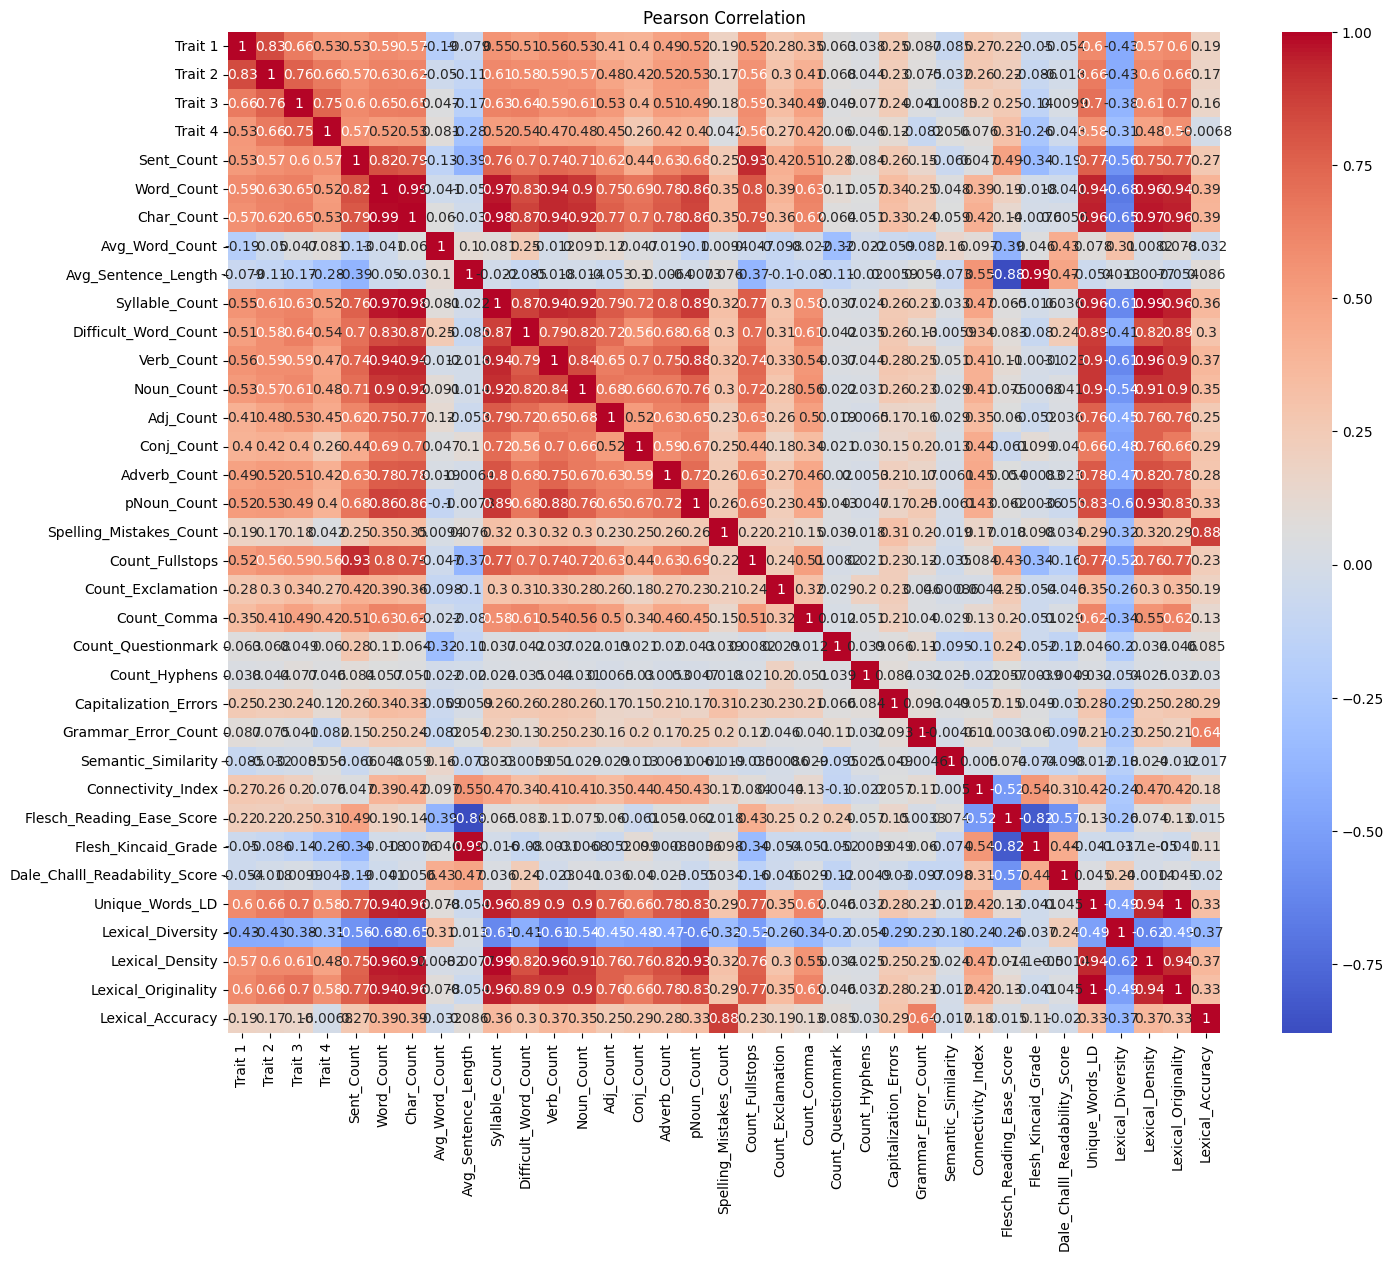

In [ ]:
correlation_pearson = df_train.corr()
plt.figure(figsize=(16,13))
sns.heatmap(correlation_pearson, annot=True, cmap="coolwarm").set_title('Pearson Correlation')

Text(0.5, 1.0, 'Spearmens Correlation')

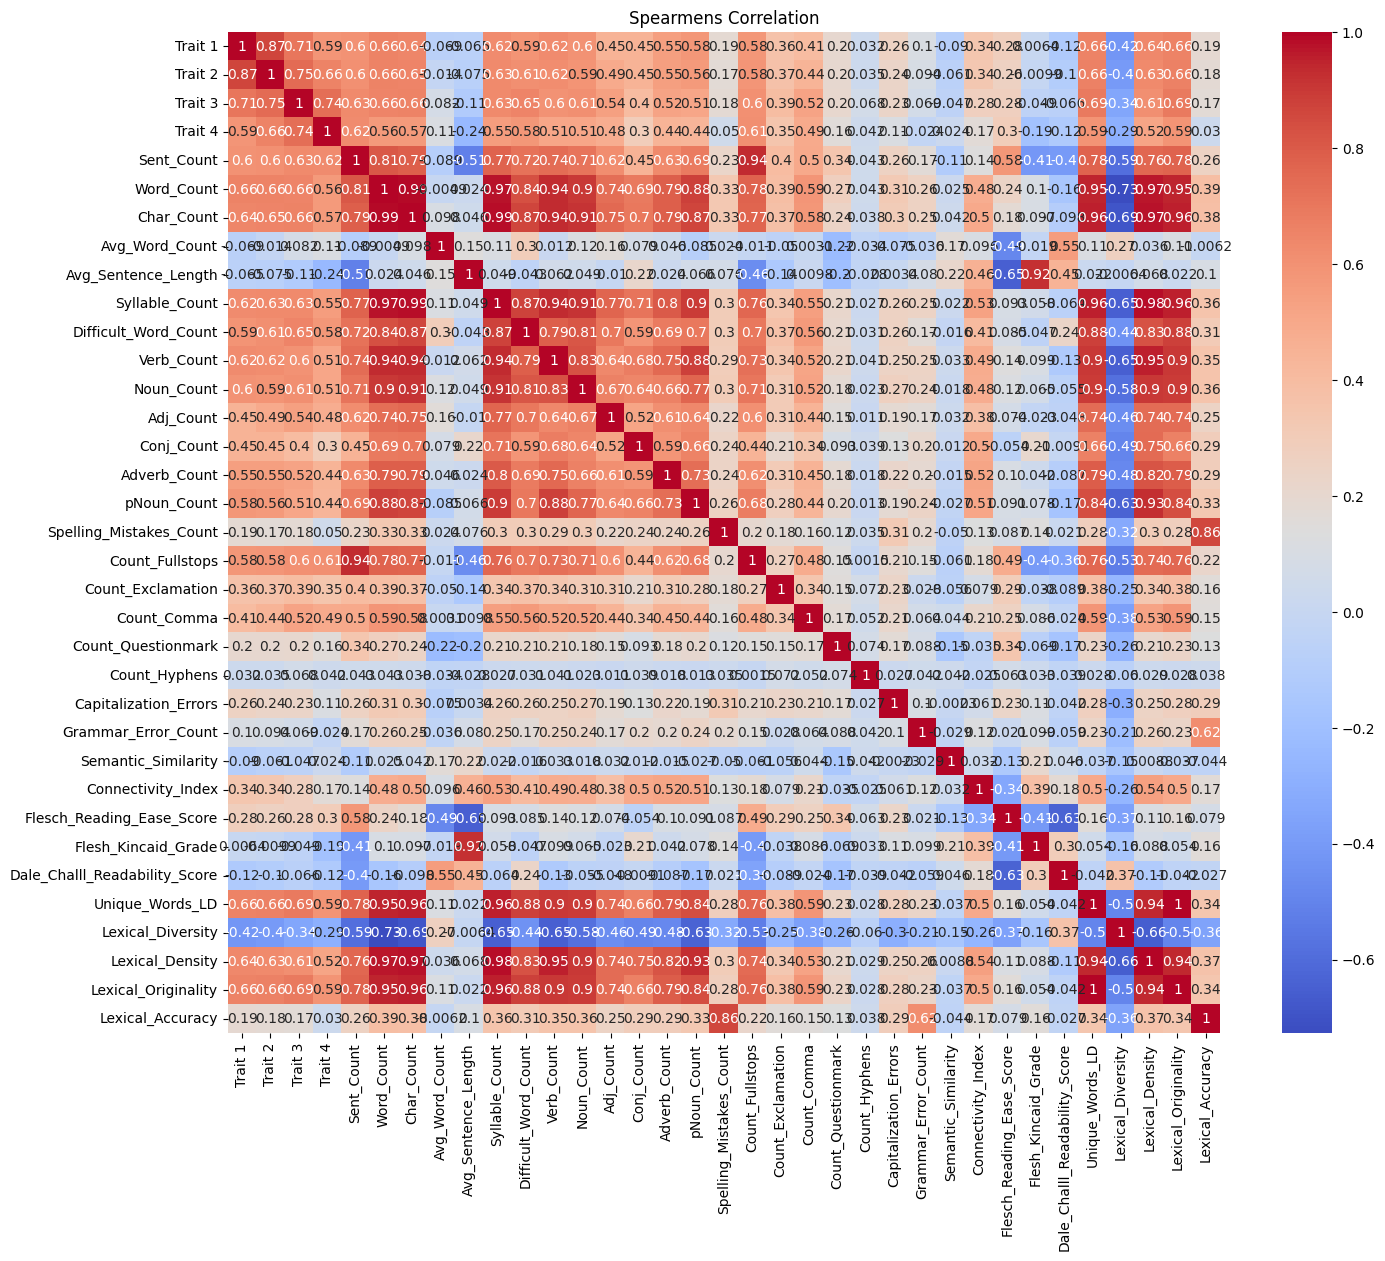

In [ ]:
#The deafult method of correlation is 'Pearson' which is used when lienar relationship between variables are gauranteed.
#Pearson is sensitive to outliers
correlation_spear = df_train.corr(method='spearman')
plt.figure(figsize=(16,13))
sns.heatmap(correlation_spear, annot=True, cmap="coolwarm").set_title('Spearmens Correlation')

### **Linear Regression**

In [ ]:
def forwardFeatureSelection(i):
  X = df_train.iloc[:,4:] 
  y = df_train.iloc[:,:4] 
  sfs = SFS(LinearRegression(),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  #X_1.shape
  return X.columns[list(sfs.k_feature_idx_)],X_1

In [ ]:
X = df_train.iloc[:,4:] 
y = df_train.iloc[:,:4] 

for i in range(5,len(X.columns)):
  selected_cols,transformed_X = forwardFeatureSelection(i)
  data_logger = MultiOutput_Regressor("Linear Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("Vanilla Linear Regression Model with SFS")
  data_logger.linearRegression(transformed_X,y)

Selected Features:  Index(['Avg_Word_Count', 'Grammar_Error_Count', 'Flesch_Reading_Ease_Score',
       'Flesh_Kincaid_Grade', 'Lexical_Originality'],
      dtype='object')
Weight: [-1.83246565e-01  8.73538423e-03  2.03486436e-02  7.30460035e-01
  6.75244085e+03]
Weight: [-8.74619373e-02  2.10361335e-02  3.39576521e-02  5.58721440e-01
  7.22495606e+03]
Weight: [-7.03748270e-02 -4.91951740e-02  1.69803809e-02  3.14988712e-02
  8.07105284e+03]
Weight: [-1.03018134e+00 -7.87548943e-02  1.75767692e-02  4.00618464e-02
  9.54200744e+03]
[[3 2 1 0 4]
 [2 3 1 0 4]
 [2 3 0 1 4]
 [2 3 1 0 4]]
[12.0, 12.0, 10.0, 19.0, 14.0, 25.0, 15.0, 15.0, 17.0, 12.0, 16.0, 16.0, 16.0, 14.0, 14.0, 17.0, 16.0, 14.0, 17.0, 14.0, 15.0, 15.0, 17.0, 15.0, 13.0, 10.0, 11.0, 13.0, 17.0, 17.0, 22.0, 13.0, 13.0, 25.0, 16.0, 16.0, 15.0, 15.0, 18.0, 13.0, 12.0, 14.0, 15.0, 11.0, 16.0, 20.0, 12.0, 12.0, 20.0, 18.0, 12.0, 13.0, 13.0, 17.0, 13.0, 11.0, 19.0, 16.0, 16.0, 33.0, 16.0, 13.0, 18.0, 12.0, 15.0, 8.0, 18.0, 17.0, 16

### **Gradient Regression** (Leave this block, Time Consuming: 7Hrs+)

In [ ]:
def forwardFeatureSelection_GBR(i):
  X = df_train.iloc[:,8:] 
  y = df_train.iloc[:,:8] 
  # Training on best parameters
  sfs = SFS(MultiOutputRegressor(ensemble.GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.5)),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  #X_1.shape
  return X.columns[list(sfs.k_feature_idx_)],X_1

In [ ]:
X = df_train.iloc[:,8:] 
y = df_train.iloc[:,:8] 
for i in range(14,len(X.columns)):
  selected_cols,transformed_X = forwardFeatureSelection_GBR(i)
  data_logger = MultiOutput_Regressor("Gradient Boosting Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("Gradient Boosting Regression Model with SFS")
  data_logger.gbr_basic(transformed_X,y)

In [ ]:
log_df.to_csv("ModelTrackingGBR.csv")

# **Approach02: Word Embedding Features**

### **Word2Vec Features**

In [ ]:
# create a list of essay strings
essays = df_essay  #defined in first block
essay_list = [ess for ess in essays]

# tokenize the string into words
tokens = [word_tokenize(ess) for ess in essay_list]

# Remove non-alphabetic tokens, such as punctuation
words_list = [[word.lower() for word in sentences if word.isalpha()] for sentences in tokens]

# Remove stopwords
words_list = [[word for word in sentence if not word in stop_words] for sentence in words_list]


In [ ]:
def word2vec_model(docs_list):
  model = Word2Vec(docs_list, min_count=1)

  # understanding the model
  # print("Dimension of Word Vectors are: ", model.vector_size)
  # word embedding vector for a specific token 'dear'
  #print(model.wv['dear'])

  vocab = list(model.wv.vocab.keys())
  df = pd.DataFrame([model.wv.word_vec(w) for w in vocab], index=vocab)
  print(df.shape)
  df.to_csv("word2vec_features.csv", index = True)
  return model


model =word2vec_model(words_list)

(9863, 100)


In [ ]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

In [ ]:
corpus = [preprocess(essay) for essay in essay_list]

In [ ]:
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x)

<ipython-input-42-db7da09bea5a>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return np.mean(model[doc], axis=0)


In [ ]:
df_d2v = pd.DataFrame(X)
df_d2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.103761,0.031381,0.202463,0.447380,-0.087136,0.925388,-0.153834,-0.493430,-0.267585,-0.080463,...,0.639755,0.022904,0.386668,-0.639635,0.232881,-0.201305,-0.396279,-0.035816,0.074702,0.098832
1,-0.052528,0.012720,0.149627,0.314724,-0.070567,0.635878,-0.114176,-0.337964,-0.173926,-0.069459,...,0.456910,0.046668,0.268550,-0.453430,0.157323,-0.153539,-0.287018,-0.006079,0.068359,0.071093
2,-0.048553,0.009505,0.162003,0.332607,-0.079512,0.672056,-0.126004,-0.352052,-0.176377,-0.077229,...,0.490036,0.058416,0.283943,-0.481994,0.162760,-0.170571,-0.307587,0.002625,0.077620,0.077845
3,-0.067053,0.013147,0.189796,0.397645,-0.091723,0.808170,-0.147345,-0.428218,-0.222922,-0.090466,...,0.584582,0.057540,0.345732,-0.578314,0.200640,-0.200457,-0.364482,-0.006464,0.084918,0.086895
4,-0.069736,0.017636,0.205543,0.429321,-0.095543,0.870386,-0.156743,-0.457497,-0.232767,-0.093165,...,0.624942,0.062759,0.366646,-0.615548,0.210687,-0.212755,-0.390286,-0.008930,0.092658,0.098436


### **Training with W2V Features**

In [ ]:
#basic model (W2V Features)
X = df_d2v
y = df_train.iloc[:,:8] 
data_logger = MultiOutput_Regressor("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with only W2V features")
data_logger.linearRegression(X,y)

#Lasso regression via GridSearch
data_logger = MultiOutput_Regressor("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV + Only W2V Features ")
data_logger.gridSearchCV(X,y,"Lasso")

#Excluding random forest since results are not good for set07

In [ ]:
log_df.to_csv('Model_Tracking07.csv')

### **Training on D2V embeddings + Stats Features**

In [ ]:
X = df_train.iloc[:,4:]
X = pd.concat([X,df_d2v], axis=1)   #Merging stats and D2V faetures
y = df_train.iloc[:,:4] 

data_logger = MultiOutput_Regressor("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with only W2V features")
data_logger.linearRegression(X,y)

#Lasso regression via GridSearch
data_logger = MultiOutput_Regressor("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV + Only W2V Features ")
data_logger.gridSearchCV(X,y,"Lasso")

In [ ]:
log_df.to_csv('Model_Tracking07.csv')

## **Model Selection**

In [ ]:
log_df = pd.read_csv("Model_Tracking07.csv", index_col=[0])
log_df.head()

In [ ]:
log_df.sort_values(['cohen_kappa_score','r2-score', 'mae'], ascending=[False, False, True])

,modelName,features_list,features_size,hyperparameters,comments,r2-score,mae,cohen_kappa_score
6,Gradient Boosting Algorithm,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",31,"({},)",Gradient Boosting Algorithm Model,49.937105,1.999363,0.813153
0,Linear Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",31,"({},)",Vanilla Linear Regression Model,34.889647,2.314850,0.753303
3,Linear Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",31,"({},)",Vanilla Linear Regression Model,34.889647,2.314850,0.753303
5,Ridge Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",31,"{'polynomial_features__degree': 1, 'ridge_regr...",Ridge regression +GridSearchCV,34.610004,2.333971,0.752153
4,Lasso Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",31,"{'lasso_regression__alpha': 0.001, 'polynomial...",Lasso Regression + GridSearchCV,34.194238,2.329509,0.751940
9,Random Forest Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",31,"({},)",Random Forest Regressor Model,30.442175,2.289994,0.751047
7,Random Forest Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",31,"({},)",Random Forest Regressor Model,-4083.049688,16.571702,0.061805
8,Random Forest Regression,"[Sent_Count, Word_Count, Char_Count, Avg_Word_...",31,"({},)",Random Forest Regressor Model,-4083.049688,16.571702,0.061805
30,Linear Regression,"Index(['Avg_Sentence_Length', 'Syllable_Count'...",25,"({},)",Vanilla Linear Regression Model with SFS,-358.236264,1058.644997,0.005493
31,Linear Regression,"Index(['Avg_Sentence_Length', 'Syllable_Count'...",26,"({},)",Vanilla Linear Regression Model with SFS,-358.236264,1058.644997,0.005493


## **Training and Testing on Best Model**

In [ ]:
model.estimators_

[GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.5),
 GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.5),
 GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.5),
 GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.5)]

In [ ]:
model.estimators_[0].feature_importances_

array([0.03169153, 0.16858444, 0.01887707, 0.10669305, 0.00813194,
       0.0110202 , 0.02548446, 0.02492899, 0.01335136, 0.01388919,
       0.00590954, 0.03003101, 0.01637192, 0.00234546, 0.01566795,
       0.01343367, 0.01160844, 0.0094306 , 0.        , 0.01100384,
       0.00569622, 0.03466448, 0.03814459, 0.06065588, 0.01640693,
       0.02030013, 0.09594124, 0.02449927, 0.05010517, 0.11026398,
       0.00486743])

In [ ]:
#Train on best features
X = df_train.iloc[:,4:]  #Skipping first 4 columns
y = df_train.iloc[:,:4]  #Selecting first 4 columns


In [ ]:
X = df_train.iloc[:,4:]  #Skipping first 8 columns
y = df_train.iloc[:,:4]  #Selecting first 8 columns

data_logger = MultiOutput_Regressor("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model")
model =data_logger.linearRegression(X,y)

In [ ]:
#save model
with open('model07.pkl', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
#Testing Data
# Testing set
df_test = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/Testing_Features_Set/EssaySet07_Testing_Features.csv", index_col =[0])
df_test.head()

,essay_id,essay_set,Essay,domain1_predictionid,predicted_score,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy,Flesh_Kincaid_Grade
3544,19564,7,"About a while back, or not to long ago I had @...",22564,16,NaN,9,180,816,3.655556,...,0.328573,18.472699,100.055000,5.856611,83,0.461111,107,0.000933,2,3.926812
3545,19565,7,A time when someone I know was patient. One da...,22565,16,NaN,14,355,1475,3.259155,...,0.354511,26.585811,101.025387,5.694834,105,0.295775,212,0.001180,13,6.237262
3546,19566,7,About I month ago my little brother was riding...,22566,16,NaN,13,152,663,3.480263,...,0.290714,11.387056,101.462045,5.463017,72,0.473684,100,0.000809,2,0.126190
3547,19567,7,When my birthday was coming up and to be patie...,22567,12,NaN,3,101,437,3.455446,...,0.429973,14.892136,90.576205,6.713396,50,0.495050,56,0.000562,1,9.311224
3548,19568,7,"The day was @DATE1. A girl named @PERSON1, @PE...",22568,20,NaN,15,241,1088,3.655602,...,0.467049,17.954178,107.331483,5.743780,83,0.344398,132,0.000933,0,2.571156


In [ ]:
y_col = "predicted_score"
X = df_test[['Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count', 'Avg_Sentence_Length', 'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count', 'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count', 'Spelling_Mistakes_Count', 'Count_Fullstops', 'Count_Exclamation', 'Count_Comma', 'Count_Questionmark', 'Count_Hyphens', 'Capitalization_Errors', 'Grammar_Error_Count', 'Semantic_Similarity', 'Connectivity_Index', 'Flesch_Reading_Ease_Score', 'Flesh_Kincaid_Grade', 'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity', 'Lexical_Density', 'Lexical_Originality', 'Lexical_Accuracy']]
y = df_test[y_col]

In [ ]:
#Loading model from file
with open('model07.pkl', 'rb') as f:
  model = pickle.load(f)

In [ ]:
#predicting results on test set
y_pred = model.predict(X)
y_pred
for trait in range(4):
  print("Trait: " , trait , end = "\n\n")
  importances = model.estimators_[trait].feature_importances_
  sorted_weights = np.sort(importances)[::-1]
  sorted_indices = np.argsort(np.abs(importances))[::-1]
  for i in range(10):
    # print(f"Feature {sorted_indices[i]}: {importances[sorted_indices[i]]:.3f}")
    print(X.columns[sorted_indices[i]])
  print("\n\n")
  

Trait:  0

Word_Count
Lexical_Originality
Avg_Word_Count
Unique_Words_LD
Flesch_Reading_Ease_Score
Lexical_Density
Connectivity_Index
Semantic_Similarity
Sent_Count
Adverb_Count



Trait:  1

Word_Count
Unique_Words_LD
Lexical_Originality
Flesch_Reading_Ease_Score
Difficult_Word_Count
Connectivity_Index
Char_Count
Sent_Count
Count_Exclamation
Count_Fullstops



Trait:  2

Lexical_Originality
Unique_Words_LD
Difficult_Word_Count
Sent_Count
Flesch_Reading_Ease_Score
Count_Comma
Word_Count
Char_Count
Count_Exclamation
Lexical_Diversity



Trait:  3

Sent_Count
Count_Fullstops
Lexical_Originality
Count_Comma
Difficult_Word_Count
Unique_Words_LD
Grammar_Error_Count
Avg_Word_Count
Lexical_Accuracy
Flesch_Reading_Ease_Score





In [ ]:
def calculate_score(y_pred):
   total = list()
   for i in range(len(y_pred)):
        score = sum(y_pred[i])
        total.append(np.floor(score))
   print(total)
   return total

In [ ]:
y_pred

array([[3.7832282 , 4.29775088, 4.37124   , 4.72183434],
       [4.54025021, 4.64675608, 4.12784161, 3.56271176],
       [3.39586826, 4.07105234, 4.38652852, 4.81795035],
       ...,
       [2.99668172, 3.70825959, 3.90081033, 3.42773246],
       [4.33214573, 4.53782563, 4.63437725, 4.82042036],
       [4.42043916, 4.71457602, 5.1935826 , 5.21463345]])

In [ ]:
total_pred = calculate_score(y_pred)
total_pred = np.rint(total_pred).astype(int)

[17.0, 16.0, 16.0, 14.0, 19.0, 15.0, 19.0, 17.0, 16.0, 19.0, 19.0, 21.0, 13.0, 16.0, 20.0, 16.0, 14.0, 14.0, 20.0, 15.0, 14.0, 18.0, 16.0, 20.0, 19.0, 15.0, 20.0, 18.0, 16.0, 19.0, 15.0, 16.0, 22.0, 19.0, 17.0, 20.0, 16.0, 15.0, 18.0, 21.0, 20.0, 13.0, 20.0, 19.0, 15.0, 18.0, 16.0, 14.0, 18.0, 22.0, 22.0, 12.0, 10.0, 15.0, 22.0, 17.0, 21.0, 11.0, 21.0, 20.0, 19.0, 13.0, 17.0, 14.0, 16.0, 13.0, 19.0, 18.0, 14.0, 16.0, 15.0, 18.0, 21.0, 16.0, 16.0, 12.0, 10.0, 23.0, 14.0, 16.0, 17.0, 16.0, 20.0, 18.0, 14.0, 16.0, 12.0, 11.0, 15.0, 22.0, 15.0, 15.0, 17.0, 18.0, 17.0, 11.0, 19.0, 18.0, 11.0, 18.0, 18.0, 20.0, 14.0, 14.0, 13.0, 17.0, 19.0, 13.0, 23.0, 18.0, 17.0, 14.0, 18.0, 19.0, 18.0, 14.0, 21.0, 13.0, 19.0, 17.0, 18.0, 16.0, 20.0, 19.0, 20.0, 15.0, 22.0, 19.0, 14.0, 14.0, 12.0, 18.0, 9.0, 20.0, 14.0, 14.0, 11.0, 13.0, 14.0, 14.0, 19.0, 16.0, 15.0, 19.0, 15.0, 20.0, 15.0, 14.0, 12.0, 15.0, 16.0, 15.0, 19.0, 15.0, 15.0, 14.0, 19.0, 19.0, 20.0, 10.0, 17.0, 13.0, 19.0, 19.0, 16.0, 13.0, 16.0

In [ ]:
total_actual = y
total_actual

3544    16
3545    16
3546    16
3547    12
3548    20
        ..
3980    18
3981    19
3982    17
3983    20
3984    15
Name: predicted_score, Length: 441, dtype: int64

In [ ]:

print(r2_score)
mae= mean_absolute_error(np.rint(total_pred), np.rint(total_actual))
print(mae)

50.72348591145251
1.6666666666666667


In [ ]:
print(cohen_kappa_score(np.rint(total_pred), np.rint(total_actual) , weights="quadratic"))
# print(cohen_score)

0.7883011325001186
